In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split
import PIL.Image as Image
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from glob import glob
import cv2
import PIL
import warnings
warnings.filterwarnings('ignore')
import os

2023-01-05 12:16:25.914619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-05 12:16:25.914655: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import pathlib
data_dir = "/home/ubuntu/Downloads/archive (6)/animals/animals"
data_dir = pathlib.Path(data_dir)

In [3]:
for image_class in os.listdir(data_dir):
    
    print(image_class)

panda
dogs
cats


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3000


In [5]:
batch_size = 32
img_height = 224
img_width = 224

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.28,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 3 classes.
Using 2160 files for training.


2023-01-05 12:16:31.817286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-05 12:16:31.817316: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-05 12:16:31.817343: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu-Zako): /proc/driver/nvidia/version does not exist
2023-01-05 12:16:31.818900: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.28,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 3 classes.
Using 840 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs', 'panda']


In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.006605332 0.99866974


In [13]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(224, 224, 3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            mode="horizontal_and_vertical")
    ]
)

In [14]:
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

In [15]:
# num_classes = len(class_names)
# num_classes

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 64)       

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
68/68 [==============================] - 92s 1s/step - loss: 1.1113 - accuracy: 0.4616 - val_loss: 0.7850 - val_accuracy: 0.6000
Epoch 2/10
68/68 [==============================] - 93s 1s/step - loss: 0.7305 - accuracy: 0.6222 - val_loss: 0.7959 - val_accuracy: 0.6429
Epoch 3/10
68/68 [==============================] - 96s 1s/step - loss: 0.6486 - accuracy: 0.6921 - val_loss: 0.6596 - val_accuracy: 0.6905
Epoch 4/10
68/68 [==============================] - 88s 1s/step - loss: 0.5451 - accuracy: 0.7523 - val_loss: 0.6781 - val_accuracy: 0.6833
Epoch 5/10
68/68 [==============================] - 87s 1s/step - loss: 0.4543 - accuracy: 0.8060 - val_loss: 0.6567 - val_accuracy: 0.7179
Epoch 6/10
68/68 [==============================] - 80s 1s/step - loss: 0.3475 - accuracy: 0.8565 - val_loss: 0.6750 - val_accuracy: 0.7250
Epoch 7/10
68/68 [==============================] - 112s 2s/step - loss: 0.2599 - accuracy: 0.8931 - val_loss: 0.7263 - val_accuracy: 0.7155
Epoch 8/10
68/68 [=

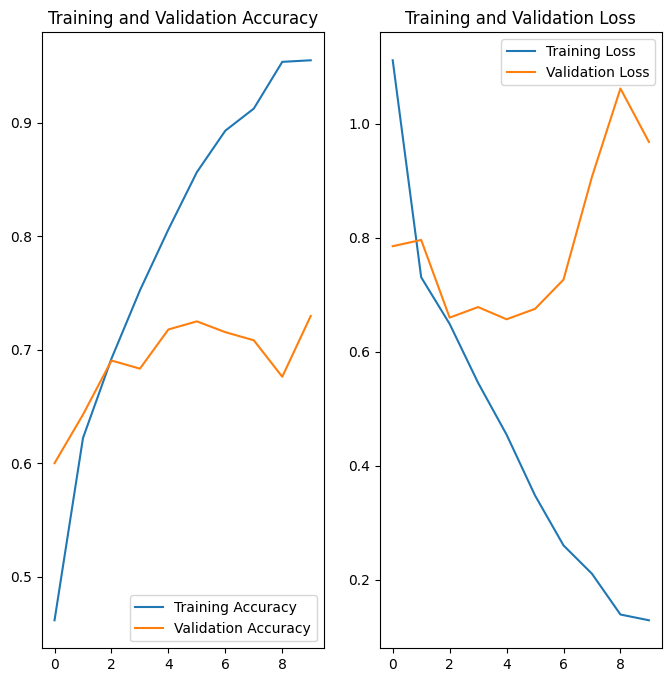

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()